In [1]:
import pandas as pd
import numpy as np
import random
import math
import scipy
from scipy import stats

from sklearn.preprocessing import StandardScaler  # for feature scaling
from sklearn.model_selection import train_test_split  # for train/test split

import matplotlib.pyplot as plt  #For representation

from sklearn.linear_model import LogisticRegression

# Netork modules
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.optim as optim

In [2]:
# Initialise sklearn LR (used for comparison)

logreg = LogisticRegression()

In [3]:
# Make synthetic data #
#=====================#


def make_synth_data(n_features = 3, n_sample = 1000, true_coefs = [1.,2.,3.]):
    # initialise
    df = pd.DataFrame()

    ## parameters
    #n_features = 3
    #n_sample = 100000

    ## True coefficients in linear function
    #true_coefs = [random.randrange(-5, 5) for i in range(n_features)]
    #true_coefs = [3, -2, 1]

    # Standardization of variables
    mean_vars = [0 for i in range(n_features)]
    var_vars = [1 for i in range(n_features)]

    # Amount of noise to add to  each variable
    noise_scale = [i**2 for i in range(n_features)]
    #noise_scale = [0.05*i/(n_features-1)**2 for i in noise_scale]
    noise_scale = [0 for i in noise_scale]

    # create normal variables
    for n in range(n_features):
        df[n] =  np.random.normal(loc=mean_vars[n], scale=var_vars[n], size=n_sample)

    # create linear combination
    df["x"] = 0
    for n in range(n_features):
        df["x"] +=  true_coefs[n]*df[n]

    # Generate outcome

    df["p"] = df.apply(lambda row: 1./(1. + math.exp(-row["x"])), axis=1)
    df["y"] = df.apply(lambda row: np.random.binomial(1, row["p"] ), axis=1)

    # Add noise to each variable
    df_noisy = df.copy()

    for n in range(n_features):
        df_noisy[n] += np.random.normal(loc=0.0, scale=noise_scale[n], size=n_sample)

    #df = df.drop(["x", "p"], axis=1)
    df_noisy = df_noisy.drop(["x", "p"], axis=1)

    # rename the indpendent variables
    ind_var_rename = dict()
    for ind_var_in in range(n_features) :
        ind_var_rename[ind_var_in] = "x"+f"{ind_var_in}"
    df = df.rename(columns=ind_var_rename)
    df_noisy = df_noisy.rename(columns=ind_var_rename)

    ind_var_names = list(ind_var_rename.values())


    # Split the data
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
    df_train, df_test, df_noisy_train, df_noisy_test = train_test_split(df, df_noisy, test_size=0.2, random_state=1234)

    # Standardize each split

    for indep_var in ind_var_names:
        df_train[indep_var] = stats.zscore(df_train[indep_var]) 
        df_test[indep_var] = stats.zscore(df_test[indep_var]) 

        df_noisy_train[indep_var] = stats.zscore(df_noisy_train[indep_var]) 
        df_noisy_test[indep_var] = stats.zscore(df_noisy_test[indep_var]) 

    # scale data
    #sc = StandardScaler()
    #df_train = sc.fit_transform(df_train)
    #X_test = sc.transform(X_test)

    return df_train, df_test, df_noisy_train, df_noisy_test, ind_var_names


In [7]:
# Create a dataset

df_train, df_test, df_noisy_train, df_noisy_test, ind_var_names = make_synth_data()


In [9]:
# Fit a logistic regression with sklearn

logreg.fit(df_train[ind_var_names], df_train["y"])

print(logreg.coef_)
#print(logreg.n_features_in_)

[[0.92302041 1.84929607 2.88848465]]


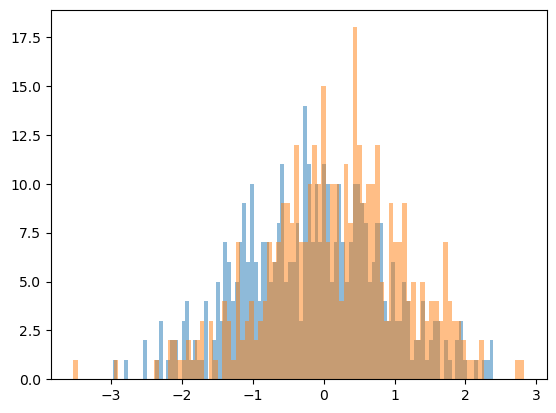

In [12]:
x1 = df_train.loc[df_train.y==0]['x0']
x2 = df_train.loc[df_train.y==1]['x0']

kwargs = dict(alpha=0.5, bins=100)

plt.hist(x1, **kwargs, label='0')
plt.hist(x2, **kwargs, label='1')
plt.show()


#plt.gca().set(title='Frequency Histogram of Diamond Depths', ylabel='Frequency')
#plt.xlim(50,75)
#plt.legend();

In [19]:

#==================#
#    Load Data     #
#==================#


class SynthDataset(Dataset):


    def __init__(self, df):
        """Initializes instance of class SynthDataset.

        Args:
            df: Pandas dataframe.

        """

#sc = StandardScaler()
#df_train = sc.fit_transform(df_train)

        # The target is binary
        self.target = ["y"]   #["flow", "handling", "respect"]
        self.features = ind_var_names
        self.data_frame = df.loc[:, self.target+self.features]
        self.n_features = len(self.features)

        # Save target and predictors
        self.x = self.data_frame[self.features]
        self.y = self.data_frame.loc[:,"y"]


    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        # Convert idx from tensor to list due to pandas bug (that arises when using pytorch's random_split)
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()

#        return [self.X.iloc[idx].values, self.y[idx]]
#        return  {"X": self.X.iloc[idx].values, 'flow': self.flow.iloc[idx].values, 'handling': self.handling.iloc[idx].values, 'respect': self.respect.iloc[idx].values}
        return  [self.x.iloc[idx].values.astype(float),  self.y.iloc[idx].astype(float)] #,  self.handling.iloc[idx].astype(float),  self.respect.iloc[idx].astype(float)]

test = SynthDataset(df_noisy)


In [20]:

# Create model
# f = wx + b, sigmoid at the end
class LogisticRegression(nn.Module):

    def __init__(self, n_input_features):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)

    def forward(self, x):
        y_predicted = torch.sigmoid(self.linear(x))
        return y_predicted
    
model = LogisticRegression(n_features)


In [21]:
#=======================#
#     LR Training       #
#=======================#


def lr_train(train_in, n_epochs=100, learn_rate = 0.01, save_name_mod = ""):

    # Load dataset
    train_dataset_orig = SynthDataset(train_in)

    train_x = torch.from_numpy(train_dataset_orig.x.to_numpy().astype(np.float32) )
    train_y = torch.from_numpy(train_dataset_orig.y.to_numpy().astype(np.float32))

    train_y = train_y.view(train_y.shape[0], 1)

    # Define the model
    net=LogisticRegression(train_dataset_orig.n_features)
    
    # Loss function
    criterion = nn.BCELoss()

    # Optimizer
    #optimizer = optim.Adam(net.parameters(), lr=learn_rate, weight_decay=w_decay)
    optimizer = torch.optim.SGD(net.parameters(), lr=learn_rate)
    #torch.optim.SGD(model.parameters(), lr=learning_rate)
    #optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    #optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)



    for epoch in range(n_epochs):

        y_pred = net(train_x )

        loss=criterion(y_pred, train_y )

        loss.backward()
        optimizer.step()
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        if (epoch+1) % 10 == 0:
            print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')        

    return net

In [22]:
test_run = lr_train(df_train, n_epochs=1000, learn_rate = 0.1, save_name_mod = "")


print(df_train.shape)

epoch: 10, loss = 0.5671
epoch: 20, loss = 0.5086
epoch: 30, loss = 0.4693
epoch: 40, loss = 0.4415
epoch: 50, loss = 0.4209
epoch: 60, loss = 0.4052
epoch: 70, loss = 0.3928
epoch: 80, loss = 0.3828
epoch: 90, loss = 0.3745
epoch: 100, loss = 0.3676
epoch: 110, loss = 0.3618
epoch: 120, loss = 0.3567
epoch: 130, loss = 0.3524
epoch: 140, loss = 0.3485
epoch: 150, loss = 0.3452
epoch: 160, loss = 0.3422
epoch: 170, loss = 0.3395
epoch: 180, loss = 0.3372
epoch: 190, loss = 0.3350
epoch: 200, loss = 0.3331
epoch: 210, loss = 0.3313
epoch: 220, loss = 0.3297
epoch: 230, loss = 0.3283
epoch: 240, loss = 0.3269
epoch: 250, loss = 0.3257
epoch: 260, loss = 0.3246
epoch: 270, loss = 0.3235
epoch: 280, loss = 0.3226
epoch: 290, loss = 0.3217
epoch: 300, loss = 0.3209
epoch: 310, loss = 0.3201
epoch: 320, loss = 0.3194
epoch: 330, loss = 0.3187
epoch: 340, loss = 0.3181
epoch: 350, loss = 0.3175
epoch: 360, loss = 0.3170
epoch: 370, loss = 0.3165
epoch: 380, loss = 0.3160
epoch: 390, loss = 0.

In [23]:
test_run.linear.weight, test_run.linear.bias, true_coefs

(Parameter containing:
 tensor([[ 2.7907, -1.8528,  0.9172]], requires_grad=True),
 Parameter containing:
 tensor([0.0074], requires_grad=True),
 [3, -2, 1])

# Working

In [283]:
def validate(loader, model, criterion, device):                       
    #correct = 0                                               
    #total = 0                                                 
    running_loss = 0.0                                        
    model.eval()
      
    with torch.no_grad():                                     
        for i, data in enumerate(loader):                     
            inputs, labels = data                             
            inputs = inputs.to(device)                        
            labels = labels.to(device)                        
            
            outputs = model(inputs.float())    

            labels_hat=outputs.float()

            #loss = criterion(labels_hat, labels1.squeeze().type(torch.LongTensor)-1)
            loss = criterion(labels_hat.double(), labels.double())

            running_loss = running_loss + loss.item()
         
    return running_loss/(i+1)

In [409]:
#=======================#
#     LR Training       #
#=======================#


def lr_train(train_in, n_epochs=50, batch_size = 30, learn_rate = 0.01, save_name_mod = ""):
    """Trains the model.
    Args:
        csv_file (str): Absolute path of the dataset used for training.
        n_epochs (int): Number of epochs to train.
    """
    # Load dataset
    train_dataset_orig = SynthDataset(train_in)

    train_size = int(0.8 * len(train_dataset_orig))
    valid_size = len(train_dataset_orig) - train_size
    train_dataset, valid_dataset = random_split(train_dataset_orig, [train_size, valid_size])

    
    # Dataloaders
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    # Use gpu if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



    # Define the model
    net=LogisticRegression(train_dataset_orig.n_features)
    
    # Loss function
    criterion = nn.BCELoss()

    # Optimizer
    #optimizer = optim.Adam(net.parameters(), lr=learn_rate, weight_decay=w_decay)
    optimizer = torch.optim.SGD(net.parameters(), lr=learn_rate)
    #optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    #optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

    # Train the net
    loss_per_iter = []
    loss_per_batch = []

    #valid_loss_per_iter = []
    valid_loss_per_batch = []

    best_loss = np.inf

    for epoch in range(n_epochs):

        running_loss = 0.0
        for i, (inputs, label) in enumerate(trainloader):
            inputs = inputs.to(device)
            label = label.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = net(inputs.float())

            label_hat=outputs.float()

            print(label_hat)
            print(label)

            # calculate loss
            #loss=criterion(label_hat, label.squeeze().type(torch.LongTensor)-1)
            loss=criterion(label_hat.double(), label.double() )

            #loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            # Save loss to plot
            running_loss += loss.item()
            loss_per_iter.append(loss.item())

        loss_per_batch.append(running_loss / (i + 1))
        running_loss = 0.0

        # Evaluate validation loss
        vloss = validate(validloader, net, criterion, device)
        valid_loss_per_batch.append(vloss)

        # If validation loss is lower than lowest then save the model
        #if vloss < best_loss:
        #    save_network(net, "best_model"+save_name_mod)
        #    best_loss = vloss

  
    print("Root mean squared error")
    print("Training:", np.sqrt(loss_per_batch[-1]))

    return{"loss_per_batch": loss_per_batch,
           "valid_loss_per_batch": valid_loss_per_batch}

    # Plot training loss curve
##    plt.plot(np.arange(len(loss_per_iter)), loss_per_iter, "-", alpha=0.5, label="Loss per epoch")
#    plt.plot(np.arange(len(loss_per_batch)), loss_per_batch, "-", alpha=0.5, label="Loss per epoch")
#    plt.plot(np.arange(len(valid_loss_per_batch)), valid_loss_per_batch, "-", alpha=0.5, label="Validation Loss per epoch")
#    #plt.plot(np.arange(len(loss_per_iter), step=4) + 3, loss_per_batch, ".-", label="Loss per mini-batch")
#    plt.xlabel("Number of epochs")
#    plt.ylabel("Loss")
#    plt.legend()
#    plt.show()

    return 

In [411]:
test_run = lr_train(df_train, n_epochs=100, batch_size = 30, learn_rate = 0.01, save_name_mod = "")

tensor([[0.4709],
        [0.4976],
        [0.3321],
        [0.4468],
        [0.4660],
        [0.3879],
        [0.7254],
        [0.2800],
        [0.3220],
        [0.3623],
        [0.5501],
        [0.7729],
        [0.2509],
        [0.4292],
        [0.2011],
        [0.5305],
        [0.7053],
        [0.5808],
        [0.3333],
        [0.4504],
        [0.4810],
        [0.4434],
        [0.5331],
        [0.5825],
        [0.2648],
        [0.3602],
        [0.6322],
        [0.4942],
        [0.1764],
        [0.5919]], grad_fn=<SigmoidBackward0>)
tensor([1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
        1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0.], dtype=torch.float64)


ValueError: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])) is deprecated. Please ensure they have the same size.

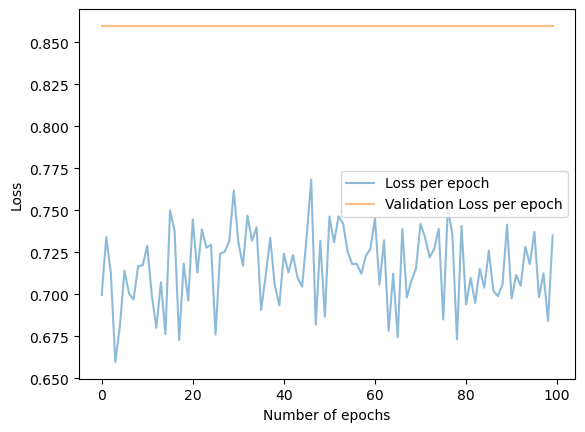

In [317]:
loss_per_batch = test_run['loss_per_batch']
valid_loss_per_batch = test_run['valid_loss_per_batch']

#plt.plot(np.arange(len(loss_per_iter)), loss_per_iter, "-", alpha=0.5, label="Loss per epoch")
plt.plot(np.arange(len(loss_per_batch)), loss_per_batch, "-", alpha=0.5, label="Loss per epoch")
plt.plot(np.arange(len(valid_loss_per_batch)), valid_loss_per_batch, "-", alpha=0.5, label="Validation Loss per epoch")
#plt.plot(np.arange(len(loss_per_iter), step=4) + 3, loss_per_batch, ".-", label="Loss per mini-batch")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [304]:
valid_loss_per_batch

[0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591,
 0.67583571249591]